## Introduction



In our last project we used data to estimate systems of food demand
using different datasets.  An output from that project was as set of
`cfe.Result` objects; these bundle together both data and the results
from the demand system estimation, and can be used for prediction as
well.  

Here we&rsquo;ll explore some of the uses of the `cfe.Result` class, using
an instance created using data from the Indian ICRISAT data.

If you don&rsquo;t already have the latest version of the `cfe` package
installed, grab it, along with some dependencies:



In [1]:
!pip install CFEDemands --upgrade
!pip install xarray

In [1]:
import cfe

cfe.Result?

An instance `r` of `cfe.Result` can be made persistent with
`r.to_dataset('my_result.ds')`, which saves the instance &ldquo;on disk&rdquo; in
[NetCDF format](https://en.wikipedia.org/wiki/NetCDF), and can be loaded using `cfe.from_dataset`.  We use
this method below to load data and demand system estimated for the
Indian ICRISAT villages:



In [1]:
#USE = "ICRISAT"
USE = "Tanzania"

# Results can be made persistent by saving them, and then re-loading...
if USE=="ICRISAT":
    r = cfe.from_dataset('./IndianICRISAT/indian_icrisat.ds')
elif USE=="Tanzania":
    r = cfe.from_dataset('./TanzanianNPS/tanzanian_nps.ds')
else:
    raise ValueError("No such value of USE")
r

Our focus earlier was on estimation, but the result `r` already has
encoded in it the results of that estimation.

There are parameters $\alpha$:



In [1]:
r.get_alpha(as_df=True)

Elasticity parameters $\beta$:



In [1]:
r.get_beta(as_df=True)

And parameters related to household characteristics $\delta$:



In [1]:
r.delta.to_dataframe().unstack('k')

The triple of paramters $(\alpha,\beta,\delta)$ completely describes
the demand system and the corresponding utility function (over the
goods we observe).



## Demands



As mentioned above, we&rsquo;ve estimated the parameters of a Frischian
demand system (demands that depend on prices and the households
marginal utility of expenditures).  But we can *compute* the
corresponding Marshallian (depends on prices and budget) or Hicksian
(depends on prices and the level of utility) demands for this same
population, using the `cfe.Result.demands` method.  

Let&rsquo;s compute Marshallian demands.  Start with a choice of budget $x$
and prices.  We&rsquo;ll use the earliest prices, and focus on
the first market we&rsquo;re interested in.



In [1]:
t = r.firstround  # First round
m = r.coords['m'][0] # First market

x = r.get_predicted_expenditures().sum('i')
x = x.where(x>0).sel(t=t,m=m).median('j') # Budget (median household)

# Note selection of prices for 1975 for market A
p = r.prices.sel(t=t,m=m).fillna(1).copy()

p.to_dataframe().fillna(1).squeeze()

Now compute demands.  The object `r` already knows what the estimated
parameters are, and uses those automatically:



In [1]:
c=r.demands(x,p)
c

# Out[7]:
# text/plain
i
Beef Including Minced Sausage                                   0.241992
Bottled/Canned Soft Drinks (Soda, Juice, Water)              1768.747224
Bread                                                         200.305064
Buns, Cakes And Biscuits                                      400.902551
Cassava Fresh                                                  13.468608
Chicken And Other Poultry                                     167.299425
Citrus Fruits (Oranges, Lemon, Tangerines, Etc.)             9340.793779
Coconuts (Mature/Immature)                                    237.404094
Cooking Bananas, Plantains                                    652.945691
Cooking Oil                                                   339.852002
Dried/Salted/Canned Fish And Seafood (Incl. Dagaa)            203.900051
Eggs                                                            1.489923
Fresh Fish And Seafood (Including Dagaa)                     2185.258613
Fresh Milk                

So we can compute demands.  Let&rsquo;s trace out a demand curve for coconuts:



# Out[14]:
# text/plain
Text(0, 0.5, 'Price')

# text/plain
<Figure size 432x288 with 1 Axes>

# image/png

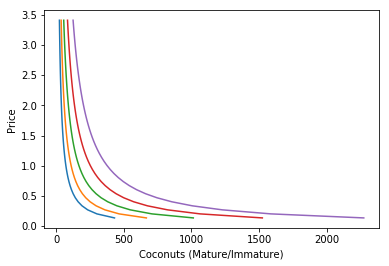

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

if USE=="ICRISAT":
    USE_GOOD = 'Coconut'
elif USE=="Tanzania":
    USE_GOOD = 'Coconuts (Mature/Immature)'
    
# Values for prices
ref_price = r.prices.sel(i=USE_GOOD,t=t,m=m)
P = np.linspace(ref_price/5,ref_price*5,50)

def my_prices(p0,p=p,i=USE_GOOD):
    p = p.copy()
    p.loc[i] = p0
    return p

for myx in [x*s for s in [.25,.5,1.,2,4]]:
    plt.plot([r.demands(myx,my_prices(p0))[USE_GOOD] for p0 in P],P)

plt.xlabel(USE_GOOD)
plt.ylabel('Price')